# Machine-Learning Approach for Cross-Domain Acronym Definition Identification
### Maya Varma and Rachel Gardner
### Autumn 2017

The large quantity of data uploaded to the Internet daily presents numerous challenges in information retrieval and analysis. A major challenge of automated text analysis is the identification of acronyms. Acronyms, such as HTML and GAN, are abbreviations formed by combining the first letters of a series of words. Although commonly used, acronyms can often be ambiguous in meaning, with each acronym resulting in numerous possible definitions. According to Liu et al. [1], almost 81% of acronyms used in MEDLINE abstracts are ambiguous, and we expect that this value is higher when considering all webpages on the Internet. Thus, an automatic tool for identifying appropriate definitions for acronyms is essential. To address this problem, we are designing a machine-learning based classifier to match ambiguous acronyms with accurate definitions based on context.



In [ ]:
import sys
sys.path.append('postgres-database/')

from urllib import urlopen
import re
import csv
import os
from collections import defaultdict, Counter
import operator
import random 
from dbFunctions import AcronymDatabase
from sklearn.feature_extraction import text, DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import tree, metrics, svm
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Preprocessing
The first step in our project is preprocessing input data. The algorithm accepts HTML files as input. The urls must be loaded from an external file, and the raw text must be extracted and cleaned. There are two sets of input urls that are loaded into the model:
- data.csv: This csv file contains a list of 1000 urls to Wikipedia articles in the categories of Medicine, Health, Biology, Computing, Electronics, and Engineering. The urls are assigned to training and testing sets in a 70:30 ratio. These Wikipedia articles come from a broad range of topics, which we are using to train/test the breadth of our model; our model needs to be able to identify definitions of a wide variety of acronyms. 
- duplicatedata.csv: This csv file contains a list of 236 urls to articles from various websites. The urls are assigned to training and testing sets in a 75:25 ratio. This dataset was manually curated to contain websites that include acronyms with multiple potential definitions. We are using these articles to train/test the depth our model; our model needs to be able to accurately identify the correct definition when presented with an ambiguous acronym.

In [2]:
#Load in csv data (contains list of HTML urls)
def loadHTMLData():
    urls = []
    with open('data/data.csv', 'rU') as data:
        reader = csv.reader(data, dialect=csv.excel_tab)
        for row in reader:
            if(len((row[0].split(','))[1]) > 0): urls.append((row[0].split(','))[1])
    return urls

def loadDuplicateData():
    train = []
    test = []
    with open('data/duplicatedata.csv', 'rU') as data:
        reader = csv.reader(data, dialect=csv.excel_tab)
        count=0
        for row in reader:
            if(len((row[0].split(','))[1]) > 0): train.append((row[0].split(','))[2])
            if(count%2 == 0 and len((row[0].split(','))[1]) > 0): train.append((row[0].split(','))[3])
            elif(count%2 == 1 and len((row[0].split(','))[1]) > 0): test.append((row[0].split(','))[3])
            count+=1
    return (train, test)

urls = loadHTMLData()
trainingUrlsDuplicates = loadDuplicateData()[0] 
testingUrlsDuplicates = loadDuplicateData()[1]
trainingUrls = trainingUrlsDuplicates + urls[:int(0.7*len(urls))]
testingUrls = testingUrlsDuplicates + urls[int(0.7*len(urls)):]
print 'Size of Training Dataset: ', len(trainingUrls)
print 'Size of Testing Dataset: ', len(testingUrls)

Size of Training Dataset:  865
Size of Testing Dataset:  355


In [3]:
#Adapted from NLTK package. Removes HTML markup from given string. 
def clean_html(html):
    # First we remove inline JavaScript/CSS:
    cleaned = re.sub(r"(?is)<(script|style).*?>.*?(</\1>)", "", html.strip())
    # Then we remove html comments. This has to be done before removing regular
    # tags since comments can contain '>' characters.
    cleaned = re.sub(r"(?s)<!--(.*?)-->[\n]?", "", cleaned)
    # Next we can remove the remaining tags:
    cleaned = re.sub(r"(?s)<.*?>", " ", cleaned)
    # Finally, we deal with whitespace
    cleaned = re.sub(r"&nbsp;", " ", cleaned)
    cleaned = re.sub(r"  ", " ", cleaned)
    cleaned = re.sub(r"  ", " ", cleaned)
    return (cleaned.strip()).split()

In [4]:
#Takes url as input. Returns list of all acronyms in webpage
def identifyAcronyms(rawText):
    acronyms = []
    #words commonly misidentified as acronyms are manually blacklisted
    blacklist = ['ABSTRACT', 'INTRODUCTION', 'CONCLUSION', 'CONCLUSIONS', 'ACKNOWLEDGEMENTS', 'RESULTS']
    for i in range(1,len(rawText)-1):
        word = rawText[i]
        word = re.sub(r'[^\w\s]','',word)
        '''
        characteristics of an acronym: all capital letters, length > 2,
        contains only alphabet characters, not in blacklist, and not part
        of a header (identified by determining if surrounding words are in all-caps)
        '''
        nextIndex = i+1
        prevIndex = i-1
        if(len(word)>2 and word[:-1].isupper() and word.isalpha() \
           and word not in blacklist and not(rawText[i-1].isupper()) \
           and not(rawText[i+1].isupper())):
            acronyms.append((word, i))    
    return acronyms

### PostGres Database
We have implemented a PostGres backend for this project. The database is populated with acronyms, corresponding context, and true definitions. The use of the database allows our project to be easily scalable.

In [5]:
db = AcronymDatabase()
#The csv file definitions.csv contains true definition labels for acronyms in each url. These labels were generated
#programmatically with an algorithm that we designed (generatePredictedDefinitions.py), and then manually refined. 
with open('label-definitions/definitions.csv', 'rU') as csvfile:
    reader = csv.reader(csvfile)
    count=0
    for row in reader:
        if(count<5215):
            ret = db.addTrueDefinition(row[0], row[1].lower(), row[2])
            count+=1
print ('Successfully added true definitions to database')
db.close()

Successfully added true definitions to database


In [8]:
db = AcronymDatabase()
for fl in (trainingUrls):
    try:
        html = urlopen(fl).read()
    except:
        continue
    rawText = clean_html(html)
    footerIndices = [i for i, x in enumerate(rawText) if x.lower()=='references']
    headerIndices = [i for i, x in enumerate(rawText) if x.lower()=='abstract']
    if(len(footerIndices)>0): rawText = rawText[:max(footerIndices)] #remove extraneous information
    if(len(headerIndices)>0): rawText = rawText[max(headerIndices):] #remove extraneous information

    def findContext(acronym, i):
        startIndex=i-15
        if (i-10 < 0): startIndex=0
        endIndex = i+15 
        if (i+10 > len(rawText)): endIndex = len(rawText)-1
        context = []
        for word in rawText[startIndex:endIndex+1]:
            word = word.lower()
            word = "".join(re.findall("[a-zA-Z]+", word))
            if(len(word)==0 or word==acronym.lower()): continue
            context.append(word)
        return " ".join(context)

    #Populate PostGres Database
    acronyms = identifyAcronyms(rawText) #list of all acronyms and corresponding index in rawtext
    for acronym, i in acronyms:
        if(db.getTrueDefinition(acronym, fl)==None): continue #If definition has not been labeled, skip
        aid = db.getAcronym(acronym) 
        if(aid==None):
            aid = db.addAcronym(acronym)
        true_definition = db.getTrueDefinition(acronym, fl)
        context = findContext(acronym, i)
        did = db.addDefinition(true_definition, context, fl, aid)
print 'Successfully added all data to database'
db.close()

Successfully added all data to database


### Analysis of Train and Test Data
The following section presents an analysis of the input data in our training and testing sets. We are using two testing datasets, which are differentiated as follows:
- Test dataset 1 - Breadth: The model classifies all the acronyms in our testing set.
- Test dataset 2 - Depth: The model classifies only the acronyms that have multiple potential definitions. Note: The depth dataset is a subset of the breadth dataset.

In [13]:
#Analysis of training set:
db = AcronymDatabase()
uniqueAcronyms = set()
totalOccurrences = 0
occurrencesPerAcronym = {}
definitionsPerAcronym = defaultdict(set)

for fl in (trainingUrls):
    try:
        html = urlopen(fl).read()
    except:
        continue
    rawText = clean_html(html)
    footerIndices = [i for i, x in enumerate(rawText) if x.lower()=='references']
    headerIndices = [i for i, x in enumerate(rawText) if x.lower()=='abstract']
    if(len(footerIndices)>0): rawText = rawText[:max(footerIndices)] #remove extraneous information
    if(len(headerIndices)>0): rawText = rawText[max(headerIndices):] #remove extraneous information
    acronyms = identifyAcronyms(rawText) #list of all acronyms and corresponding index in rawtext
    for acronym, i in acronyms:
        if(db.getTrueDefinition(acronym, fl)==None): continue #If definition has not been labeled, skip
        else:
            uniqueAcronyms.add(acronym)
            totalOccurrences+=1
            definitionsPerAcronym[acronym].add(db.getTrueDefinition(acronym, fl))
            
            
print '---Training Dataset: Analysis---'
print 'Number of unique acronyms: ', (len(uniqueAcronyms))
print 'Total number of occurrences of acronyms in text: ', totalOccurrences
print 'Average number of occurrences of each acronym in text: ', (float(totalOccurrences)/len(uniqueAcronyms))
numDefs=0
for elem in definitionsPerAcronym:
    numDefs+=len(definitionsPerAcronym[elem])
print 'Average number of definitions per acronym: ', (float(numDefs)/len(uniqueAcronyms))
stdev = 0
for elem in definitionsPerAcronym:
    stdev += (((float(numDefs)/len(uniqueAcronyms)) - len(definitionsPerAcronym[elem]))**2)
stdev = stdev/len(definitionsPerAcronym)
stdev = stdev**(0.5)
print 'Standard deviation of number of definitions per acronym: ', stdev
db.close()

---Training Dataset: Analysis---
Number of unique acronyms:  3038
Total number of occurrences of acronyms in text:  10946
Average number of occurrences of each acronym in text:  3.6030283081
Average number of definitions per acronym:  1.12409479921
Standard deviation of number of definitions per acronym:  0.404962738026


In [12]:
#Analysis of testing set (breadth):
db = AcronymDatabase()
uniqueAcronyms = set()
totalOccurrences = 0
occurrencesPerAcronym = {}
definitionsPerAcronym = defaultdict(set)

for fl in (testingUrls):
    try:
        html = urlopen(fl).read()
    except:
        continue
    rawText = clean_html(html)
    footerIndices = [i for i, x in enumerate(rawText) if x.lower()=='references']
    headerIndices = [i for i, x in enumerate(rawText) if x.lower()=='abstract']
    if(len(footerIndices)>0): rawText = rawText[:max(footerIndices)] #remove extraneous information
    if(len(headerIndices)>0): rawText = rawText[max(headerIndices):] #remove extraneous information
    acronyms = identifyAcronyms(rawText) #list of all acronyms and corresponding index in rawtext
    for acronym, i in acronyms:
        if(db.getTrueDefinition(acronym, fl)==None): continue #If definition has not been labeled, skip
        else:
            uniqueAcronyms.add(acronym)
            totalOccurrences+=1
            definitionsPerAcronym[acronym].add(db.getTrueDefinition(acronym, fl))
            
            
print '---Testing Dataset - Breadth: Analysis---'
print 'Number of unique acronyms: ', (len(uniqueAcronyms))
print 'Total number of occurrences of acronyms in text: ', totalOccurrences
print 'Average number of occurrences of each acronym in text: ', (float(totalOccurrences)/len(uniqueAcronyms))
numDefs=0
for elem in definitionsPerAcronym:
    numDefs+=len(definitionsPerAcronym[elem])
print 'Average number of definitions per acronym: ', (float(numDefs)/len(uniqueAcronyms))
stdev = 0
for elem in definitionsPerAcronym:
    stdev += (((float(numDefs)/len(uniqueAcronyms)) - len(definitionsPerAcronym[elem]))**2)
stdev = stdev/len(definitionsPerAcronym)
stdev = stdev**(0.5)
print 'Standard deviation of number of definitions per acronym: ', stdev
db.close()

---Testing Dataset - Breadth: Analysis---
Number of unique acronyms:  612
Total number of occurrences of acronyms in text:  2832
Average number of occurrences of each acronym in text:  4.62745098039
Average number of definitions per acronym:  1.08496732026
Standard deviation of number of definitions per acronym:  0.317212376402


In [11]:
#Analysis of testing set (depth):
db = AcronymDatabase()
uniqueAcronyms = set()
totalOccurrences = 0
occurrencesPerAcronym = {}
definitionsPerAcronym = defaultdict(set)

for fl in (testingUrlsDuplicates):
    try:
        html = urlopen(fl).read()
    except:
        print fl
        continue
    rawText = clean_html(html)
    footerIndices = [i for i, x in enumerate(rawText) if x.lower()=='references']
    headerIndices = [i for i, x in enumerate(rawText) if x.lower()=='abstract']
    if(len(footerIndices)>0): rawText = rawText[:max(footerIndices)] #remove extraneous information
    if(len(headerIndices)>0): rawText = rawText[max(headerIndices):] #remove extraneous information
    acronyms = identifyAcronyms(rawText) #list of all acronyms and corresponding index in rawtext
    for acronym, i in acronyms:
        if(db.getTrueDefinition(acronym, fl)==None): continue #If definition has not been labeled, skip
        else:
            uniqueAcronyms.add(acronym)
            totalOccurrences+=1
            definitionsPerAcronym[acronym].add(db.getTrueDefinition(acronym, fl))
            
            
print '---Testing Dataset - Depth: Analysis---'
print 'Number of unique acronyms: ', (len(uniqueAcronyms))
print 'Total number of occurrences of acronyms in text: ', totalOccurrences
print 'Average number of occurrences of each acronym in text: ', (float(totalOccurrences)/len(uniqueAcronyms))
numDefs=0
for elem in definitionsPerAcronym:
    numDefs+=len(definitionsPerAcronym[elem])
print 'Average number of definitions per acronym: ', (float(numDefs)/len(uniqueAcronyms))
stdev = 0
for elem in definitionsPerAcronym:
    stdev += (((float(numDefs)/len(uniqueAcronyms)) - len(definitionsPerAcronym[elem]))**2)
stdev = stdev/len(definitionsPerAcronym)
stdev = stdev**(0.5)
print 'Standard deviation of number of definitions per acronym: ', stdev
db.close()

---Testing Dataset - Depth: Analysis---
Number of unique acronyms:  26
Total number of occurrences of acronyms in text:  925
Average number of occurrences of each acronym in text:  35.5769230769
Average number of definitions per acronym:  2.03846153846
Standard deviation of number of definitions per acronym:  0.337498630284


## Extracting Features
Context is used to create feature vectors for each acronym. The words surrounding an acronym are counted and stored as a feature vector. Stop words (words that provide no meaning, such as "the" and "an") are excuded from feature vectors. The acronym itself is added in as a heavily weighted feature.

In [28]:
db = AcronymDatabase()

In [8]:
def loadGloveModel(gloveFile):
    print "Loading Glove Model"
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print "Done.",len(model)," words loaded!"
    return model

model = loadGloveModel('glove.6B.50d.txt')

Loading Glove Model
Done. 400000  words loaded!
[ 1.5254   -0.62415   0.46343   0.86997   1.0652    1.6919    0.36667
 -0.18018   1.7664    0.68529   0.93934  -0.59654  -0.012565  0.19657
  0.57104   0.48641  -0.28174  -1.2343    0.47888  -0.24682  -0.086103
 -0.52538   0.81786   0.23602  -0.031694 -0.9552   -0.83327  -0.43082
 -0.29061  -1.5646    1.8458   -1.7926   -0.27685  -1.1984    1.0755
  0.20317   0.50459   0.82424   0.38877   0.29694   0.12745  -0.33873
  0.24523   0.51359   0.66725  -0.48271   1.5093    0.16717  -0.50899
 -0.66316 ]


In [53]:
#Convert training data to sparse vectors
tokenize = CountVectorizer().build_tokenizer()
true_defs = []
def features(cad):
    acronym = cad[0]
    context = cad[1]
    if(len(cad)==3): true_defs.append(cad[2])
    terms = tokenize(context)
    d = {acronym: 50}
    count=0
    countDict = {}
    for t in terms:
        if(t not in text.ENGLISH_STOP_WORDS):
            countDict[t] = d.get(t, 0) + 1
    termsList = [pair[0] for pair in sorted(countDict.items(), key=lambda item: item[1])]
    for t in termsList:
        if(t not in text.ENGLISH_STOP_WORDS and count<=3):
            try:
                #print t
                vec = model[t]
                for i in range(0,len(vec)):
                    d[str((count*20)+i)]=vec[i]
                count+=1
            except:
                continue
    #print d, len(d), sorted(d.keys())
    return d

#np.set_printoptions(threshold=np.nan)
cadList = db.getContextAcronymList()
vect = DictVectorizer()
X_train = vect.fit_transform(features(d) for d in cadList)
print X_train.toarray()
#print cadList[2]
#print vect.get_feature_names()
#print true_defs

[[ 1.49 -0.24 -0.21 ...,  0.    0.    0.  ]
 [ 0.38 -0.03  1.05 ...,  0.    0.    0.  ]
 [ 1.25  0.12 -0.86 ...,  0.    0.    0.  ]
 ..., 
 [ 0.26  0.06 -0.4  ...,  0.    0.    0.  ]
 [-0.35 -0.23  0.97 ...,  0.    0.    0.  ]
 [ 0.91  0.28  0.83 ...,  0.    0.    0.  ]]


## Train Machine Learning Classifier
A machine learning classifier was created and fit to the data.

In [ ]:
#Tune hyperparameters
parameter_candidates = [
  {'C': [1], 
   'gamma': [0.001, 0.0001]}
]
parameters_nb = [
    {'alpha': [0.01, 0.1, 0.5, 1]}
]
parameters_tree = [{"max_depth": [3, None],
              "max_features": [1, 2, None],
              "min_samples_leaf": [1, 2, 3],
              "criterion": ["gini", "entropy"]}]

In [ ]:
clf = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1).fit(X_train, true_defs)
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)


In [ ]:
clf = GridSearchCV(estimator=MultinomialNB(), param_grid=parameters_nb, n_jobs=-1, cv=1).fit(X_train, true_defs)
print('Best alpha:',clf.best_estimator_.alpha)

In [ ]:
clf = GridSearchCV(estimator=tree.DecisionTreeClassifier(), param_grid=parameters_tree, n_jobs=-1).fit(X_train, true_defs)
print('Best Max Depth:',clf.best_estimator_.max_depth) 
print('Best Max Features:',clf.best_estimator_.max_features)
print('Best Min Samples:',clf.best_estimator_.min_samples_leaf)
print('Best Criterion:',clf.best_estimator_.criterion)

In [ ]:
#clf1 = MultinomialNB(alpha=0.09).fit(X_train, true_defs)
#print 'Trained Model 1'
clf2 = svm.LinearSVC(C=1).fit(X_train, true_defs)
print 'Trained Model 2'
clf3 = tree.DecisionTreeClassifier(min_samples_leaf=1).fit(X_train, true_defs)
print 'Trained Model 3'
clf4 = RandomForestClassifier().fit(X_train, true_defs)
print 'Trained Model 4'

Trained Model 2


## Test Machine Learning Classifier
The accuracy of the classifier was tested on the training dataset and testing dataset.

In [41]:
#Calculate training accuracy
trainData = []
y_true = []
for fl in (trainingUrls):
    #print "URL Index: %d" % urls.index(fl)
    try:
        html = urlopen(fl).read()
    except:
        continue
    rawText = clean_html(html)
    footerIndices = [i for i, x in enumerate(rawText) if x.lower()=='references']
    headerIndices = [i for i, x in enumerate(rawText) if x.lower()=='abstract']
    if(len(footerIndices)>0): rawText = rawText[:max(footerIndices)] #remove extraneous information
    if(len(headerIndices)>0): rawText = rawText[max(headerIndices):] #remove extraneous information

    def findContext(acronym, i):
        startIndex=i-15
        if (i-10 < 0): startIndex=0
        endIndex = i+15 
        if (i+10 > len(rawText)): endIndex = len(rawText)-1
        context = []
        for word in rawText[startIndex:endIndex+1]:
            word = word.lower()
            word = "".join(re.findall("[a-zA-Z]+", word))
            if(len(word)==0 or word==acronym.lower()): continue
            context.append(word)
        return " ".join(context)

    #Populate PostGres Database
    acronyms = identifyAcronyms(rawText) #list of all acronyms and corresponding index in rawtext
    for acronym, i in acronyms:
        if(db.getTrueDefinition(acronym, fl)==None): continue #Definition has been labeled in database
        context = findContext(acronym, i)
        trainData.append((acronym, context))
        y_true.append(db.getTrueDefinition(acronym, fl))        

In [43]:
X_new_counts = vect.transform(features(d) for d in trainData)
#predicted1 = clf1.predict(X_new_counts)
predicted2 = clf2.predict(X_new_counts)
predicted3 = clf3.predict(X_new_counts)
predicted4 = clf4.predict(X_new_counts)
#for train, definition, true in zip(trainData, predicted, y_true):
#    if(true!=definition): print('%s => %s, %s' % (train[0], definition, true))

#print metrics.precision_recall_fscore_support(y_true, predicted, average='weighted')
#print "Prediction Accuracy - Multinomial NB: ", accuracy_score(y_true, predicted1)
#print metrics.precision_recall_fscore_support(y_true, predicted1, average='weighted')
print "Prediction Accuracy - SVC: ", accuracy_score(y_true, predicted2)
print metrics.precision_recall_fscore_support(y_true, predicted2, average='weighted')
print "Prediction Accuracy - Decision Tree: ", accuracy_score(y_true, predicted3)
print metrics.precision_recall_fscore_support(y_true, predicted3, average='weighted')
print "Prediction Accuracy - Random Forest: ", accuracy_score(y_true, predicted4)
print metrics.precision_recall_fscore_support(y_true, predicted4, average='weighted')
#print(metrics.classification_report(y_true, predicted1))
#print(metrics.classification_report(y_true, predicted2))
#print(metrics.classification_report(y_true, predicted3))
#print(metrics.classification_report(y_true, predicted4))

Prediction Accuracy - SVC:  0.999634402705
(0.99959188381670538, 0.99963440270542003, 0.99959081876548828, None)
Prediction Accuracy - Decision Tree:  0.999725802029
(0.99974408189379405, 0.99972580202906502, 0.99970859274207324, None)
Prediction Accuracy - Random Forest:  0.994516040581
(0.99317994010051081, 0.99451604058129972, 0.99336464893700038, None)


/Users/mayavarma/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
testData = []
y_true_test = []
for fl in (testingUrls):
    #print "URL Index: %d" % urls.index(fl)
    try:
        html = urlopen(fl).read()
    except:
        continue
    rawText = clean_html(html)
    footerIndices = [i for i, x in enumerate(rawText) if x.lower()=='references']
    headerIndices = [i for i, x in enumerate(rawText) if x.lower()=='abstract']
    if(len(footerIndices)>0): rawText = rawText[:max(footerIndices)] #remove extraneous information
    if(len(headerIndices)>0): rawText = rawText[max(headerIndices):] #remove extraneous information

    def findContext(acronym, i):
        startIndex=i-15
        if (i-10 < 0): startIndex=0
        endIndex = i+15 
        if (i+10 > len(rawText)): endIndex = len(rawText)-1
        context = []
        for word in rawText[startIndex:endIndex+1]:
            word = word.lower()
            word = "".join(re.findall("[a-zA-Z]+", word))
            if(len(word)==0 or word==acronym.lower()): continue
            context.append(word)
        return " ".join(context)

    #Populate PostGres Database
    acronyms = identifyAcronyms(rawText) #list of all acronyms and corresponding index in rawtext
    for acronym, i in acronyms:
        if(db.getTrueDefinition(acronym, fl)==None): continue #Definition has been labeled in database
        if(db.getTrueDefinition(acronym, fl) not in y_true): continue
        context = findContext(acronym, i)
        testData.append((acronym, context))
        y_true_test.append(db.getTrueDefinition(acronym, fl))        


In [45]:
X_new_counts = vect.transform(features(d) for d in testData)
#predicted1 = clf1.predict(X_new_counts)
predicted2 = clf2.predict(X_new_counts)
predicted3 = clf3.predict(X_new_counts)
predicted4 = clf4.predict(X_new_counts)
#for test, definition, true in zip(testData, predicted, y_true_test):
    #if(definition==true): print('Correct: %s => %s, %s' % (test[0], definition, true))
#    if(definition!=true): print('Error: %s => %s, %s' % (test[0], definition, true))
#print "Prediction Accuracy - Multinomial NB: ", accuracy_score(y_true_test, predicted1)
#print metrics.precision_recall_fscore_support(y_true_test, predicted1, average='weighted')
print "Prediction Accuracy - SVC: ", accuracy_score(y_true_test, predicted2)
print metrics.precision_recall_fscore_support(y_true_test, predicted2, average='weighted')
print "Prediction Accuracy - Decision Tree: ", accuracy_score(y_true_test, predicted3)
print metrics.precision_recall_fscore_support(y_true_test, predicted3, average='weighted')
print "Prediction Accuracy - Random Forest: ", accuracy_score(y_true_test, predicted4)
print metrics.precision_recall_fscore_support(y_true_test, predicted4, average='weighted')
#print(metrics.classification_report(y_true_test, predicted1))
#print(metrics.classification_report(y_true_test, predicted2))
#print(metrics.classification_report(y_true_test, predicted3))
#print(metrics.classification_report(y_true_test, predicted4))

Prediction Accuracy - SVC:  0.902231668438
(0.90794035447296328, 0.90223166843783209, 0.89663168930798354, None)
Prediction Accuracy - Decision Tree:  0.810308182784
(0.86749408830036323, 0.81030818278427208, 0.82152155145256744, None)
Prediction Accuracy - Random Forest:  0.604675876727
(0.65902486862571008, 0.60467587672688627, 0.57870750717400588, None)


/Users/mayavarma/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


/Users/mayavarma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


Normalized confusion matrix
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


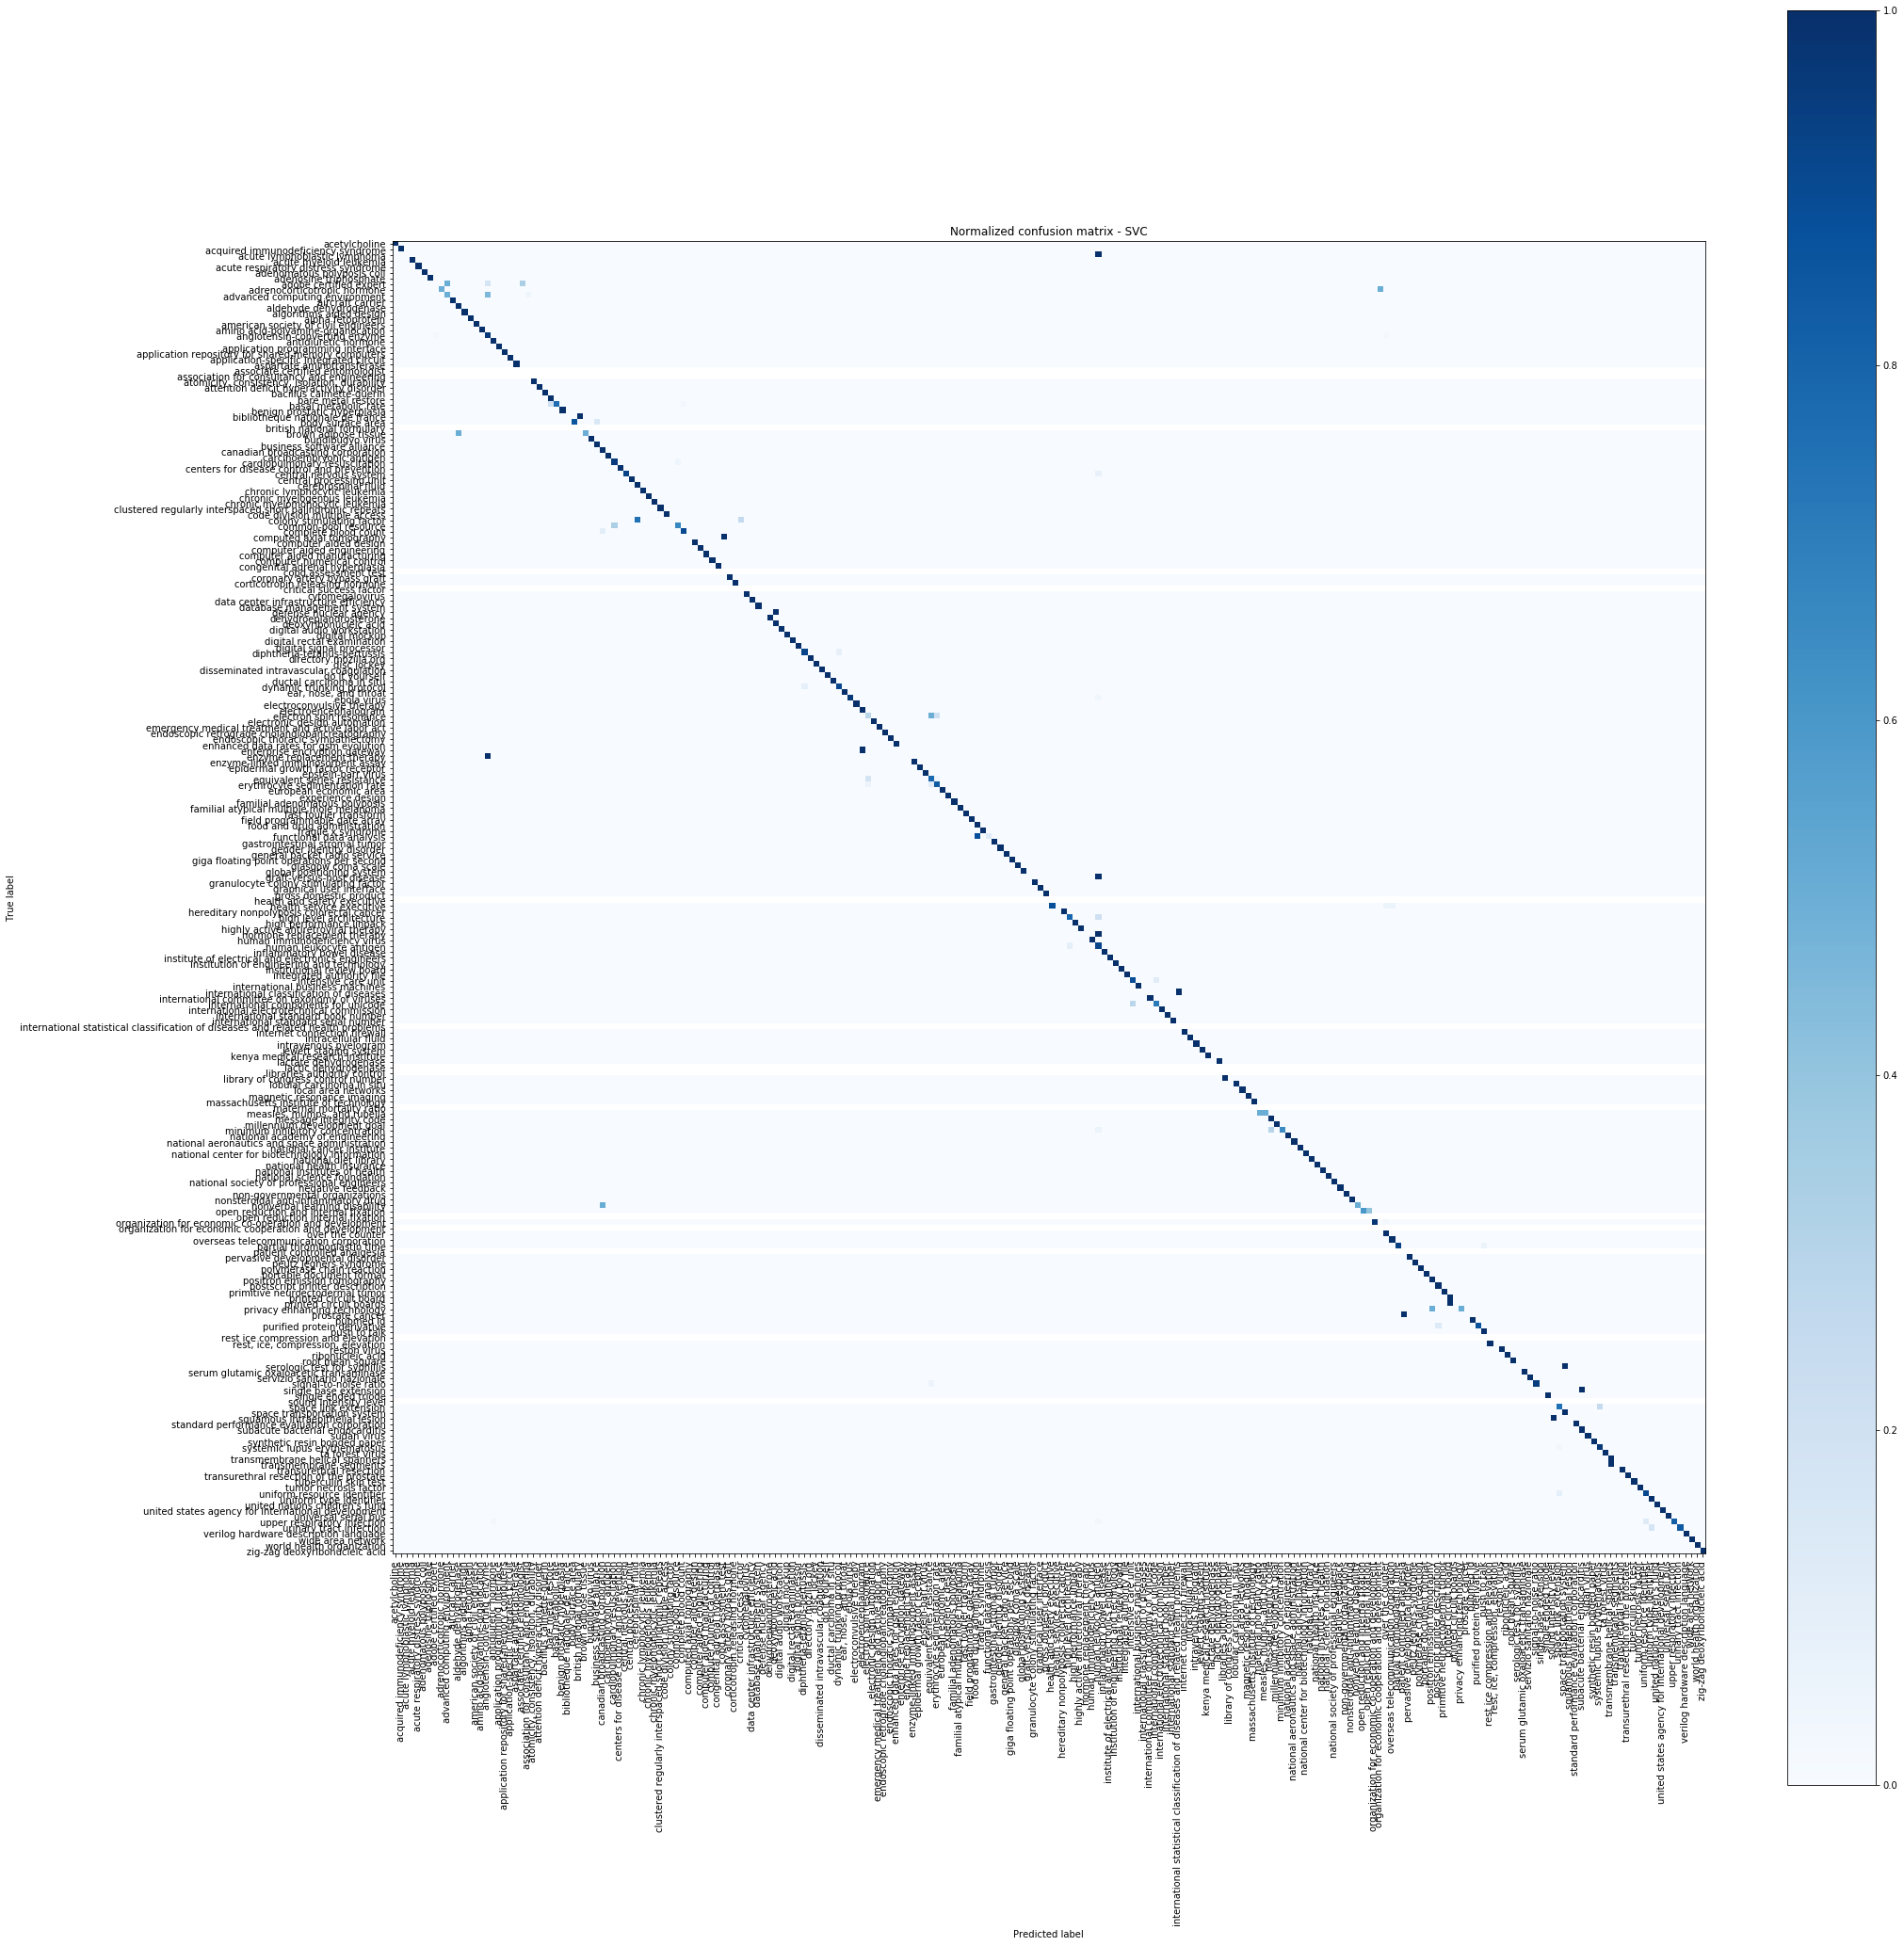

Normalized confusion matrix
[[  0.   0.   0. ...,   0.   0.   0.]
 [ nan  nan  nan ...,  nan  nan  nan]
 [  0.   0.   1. ...,   0.   0.   0.]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [  0.   0.   0. ...,   0.   0.   1.]]


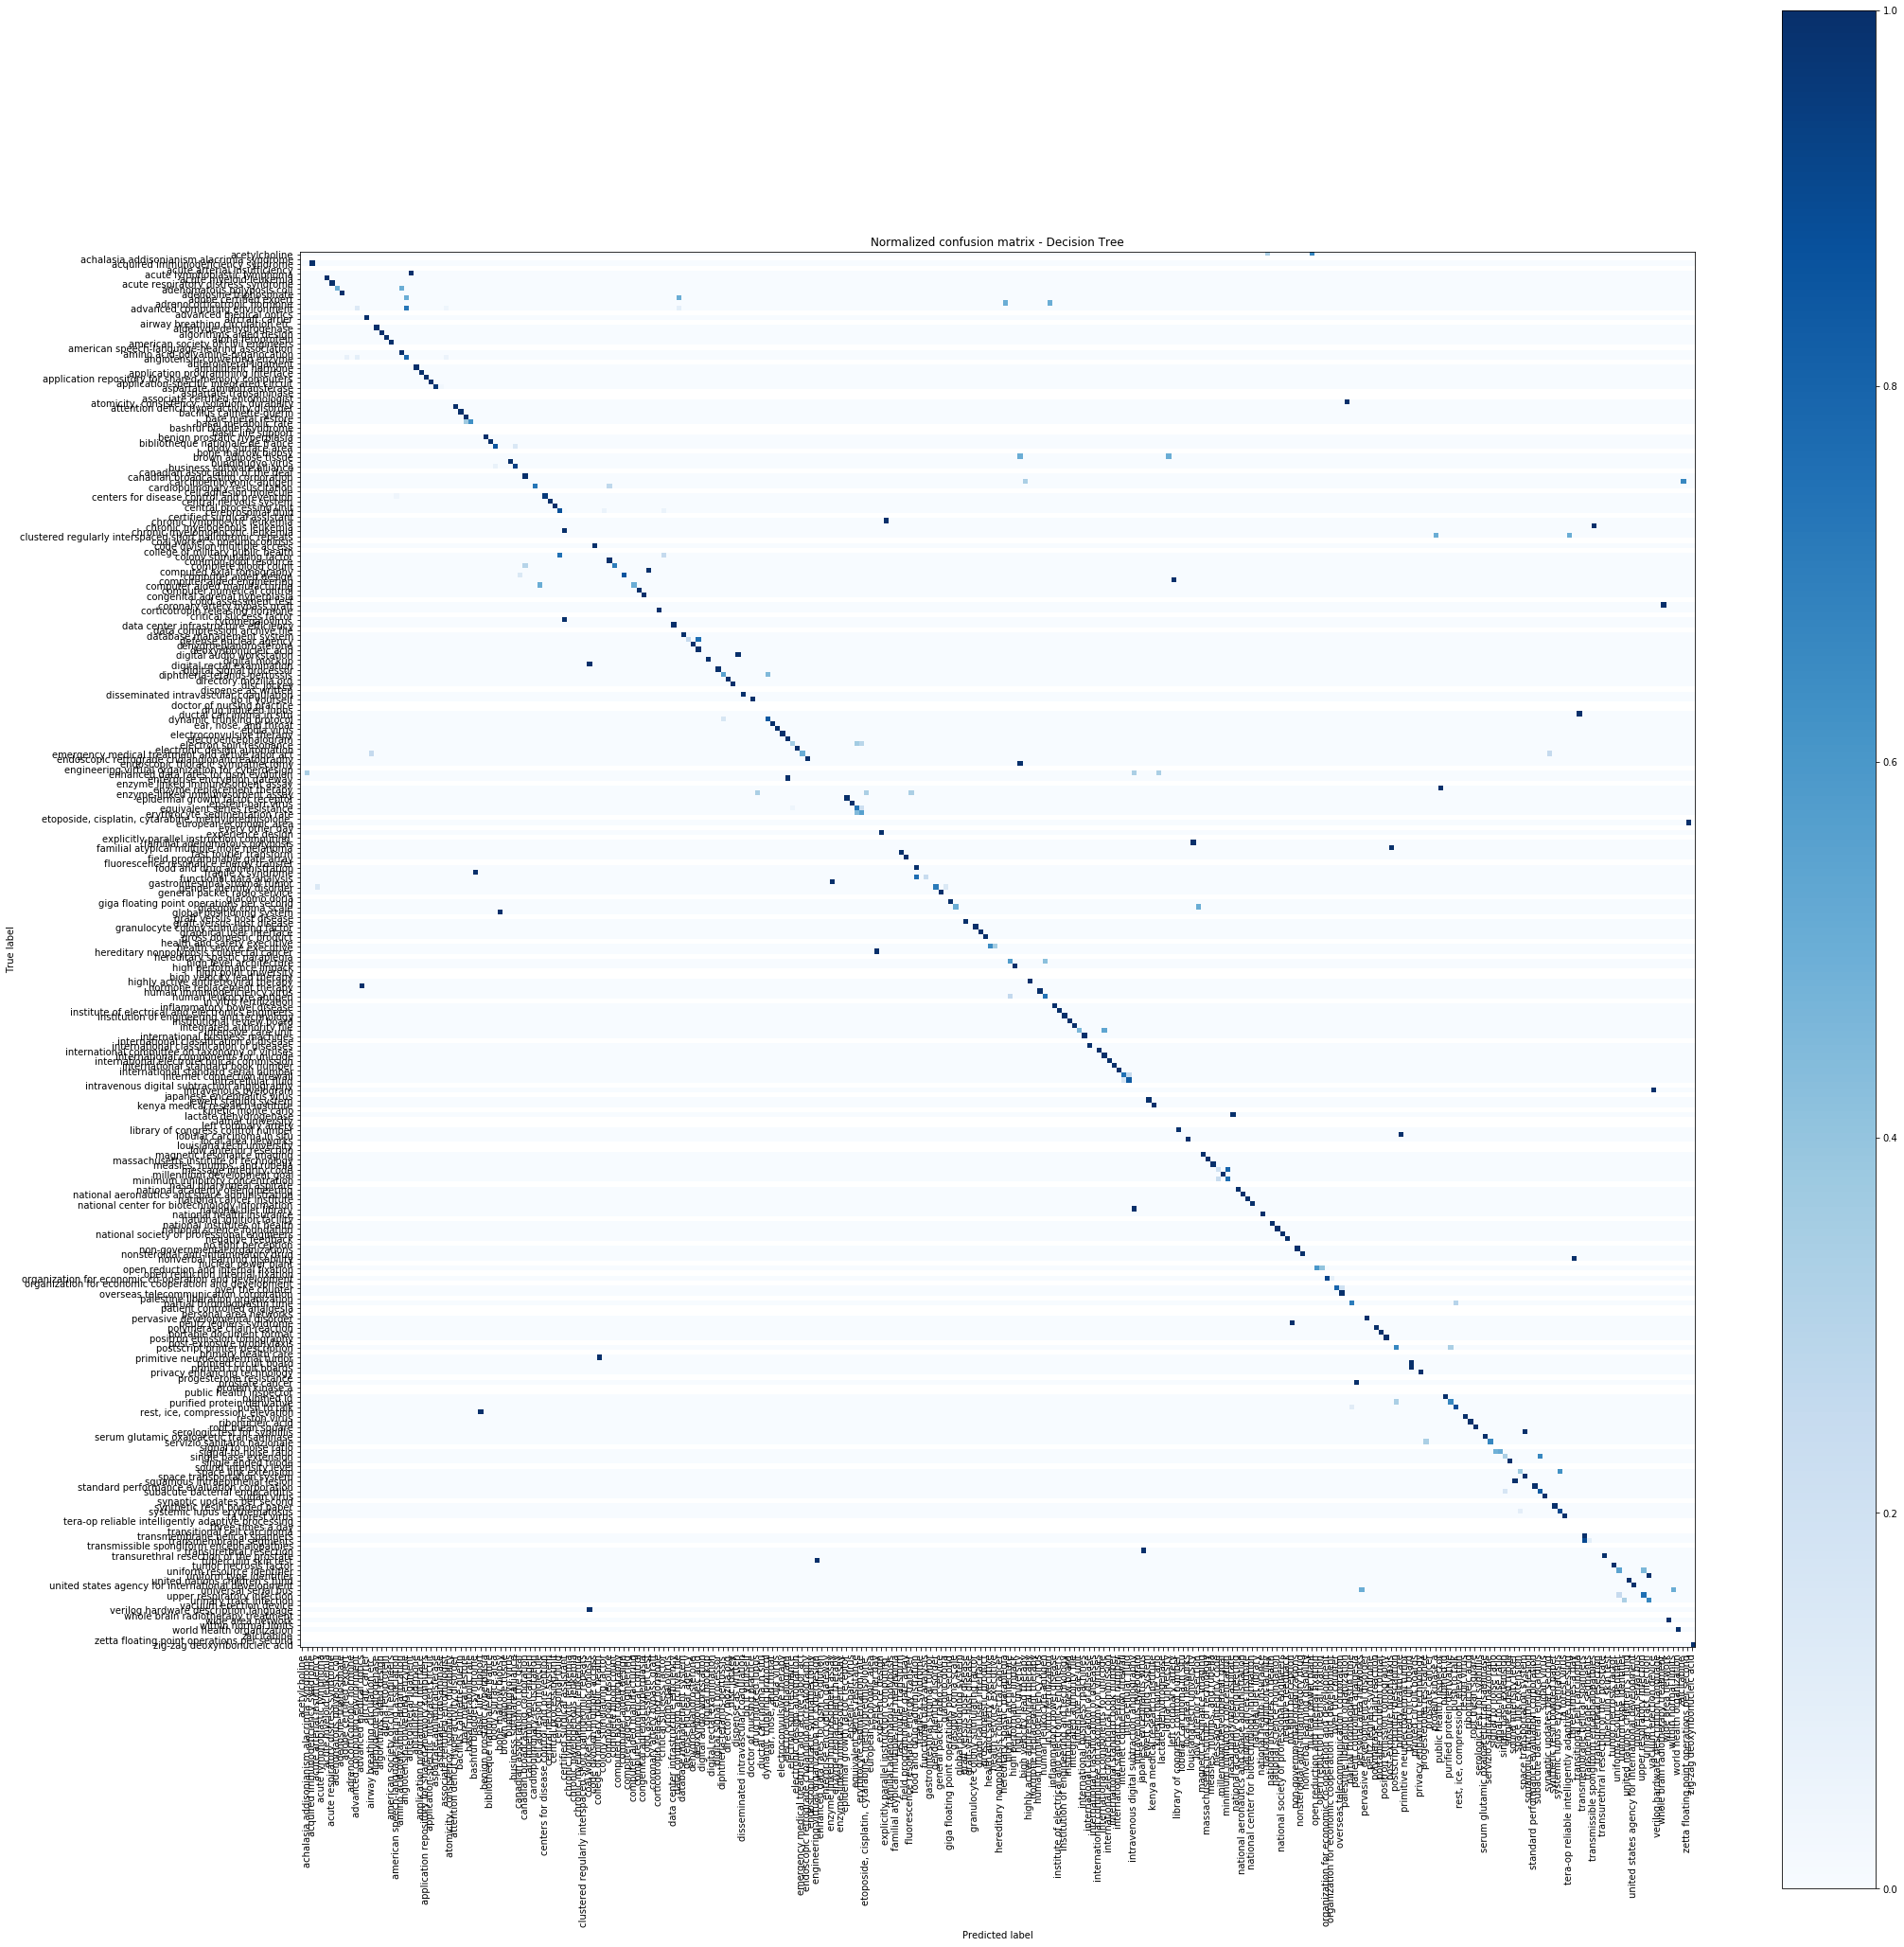

Normalized confusion matrix
[[  nan   nan   nan ...,   nan   nan   nan]
 [  nan   nan   nan ...,   nan   nan   nan]
 [  nan   nan   nan ...,   nan   nan   nan]
 ..., 
 [ 0.    0.03  0.   ...,  0.14  0.    0.  ]
 [ 0.    0.    0.   ...,  0.    1.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.  ]]


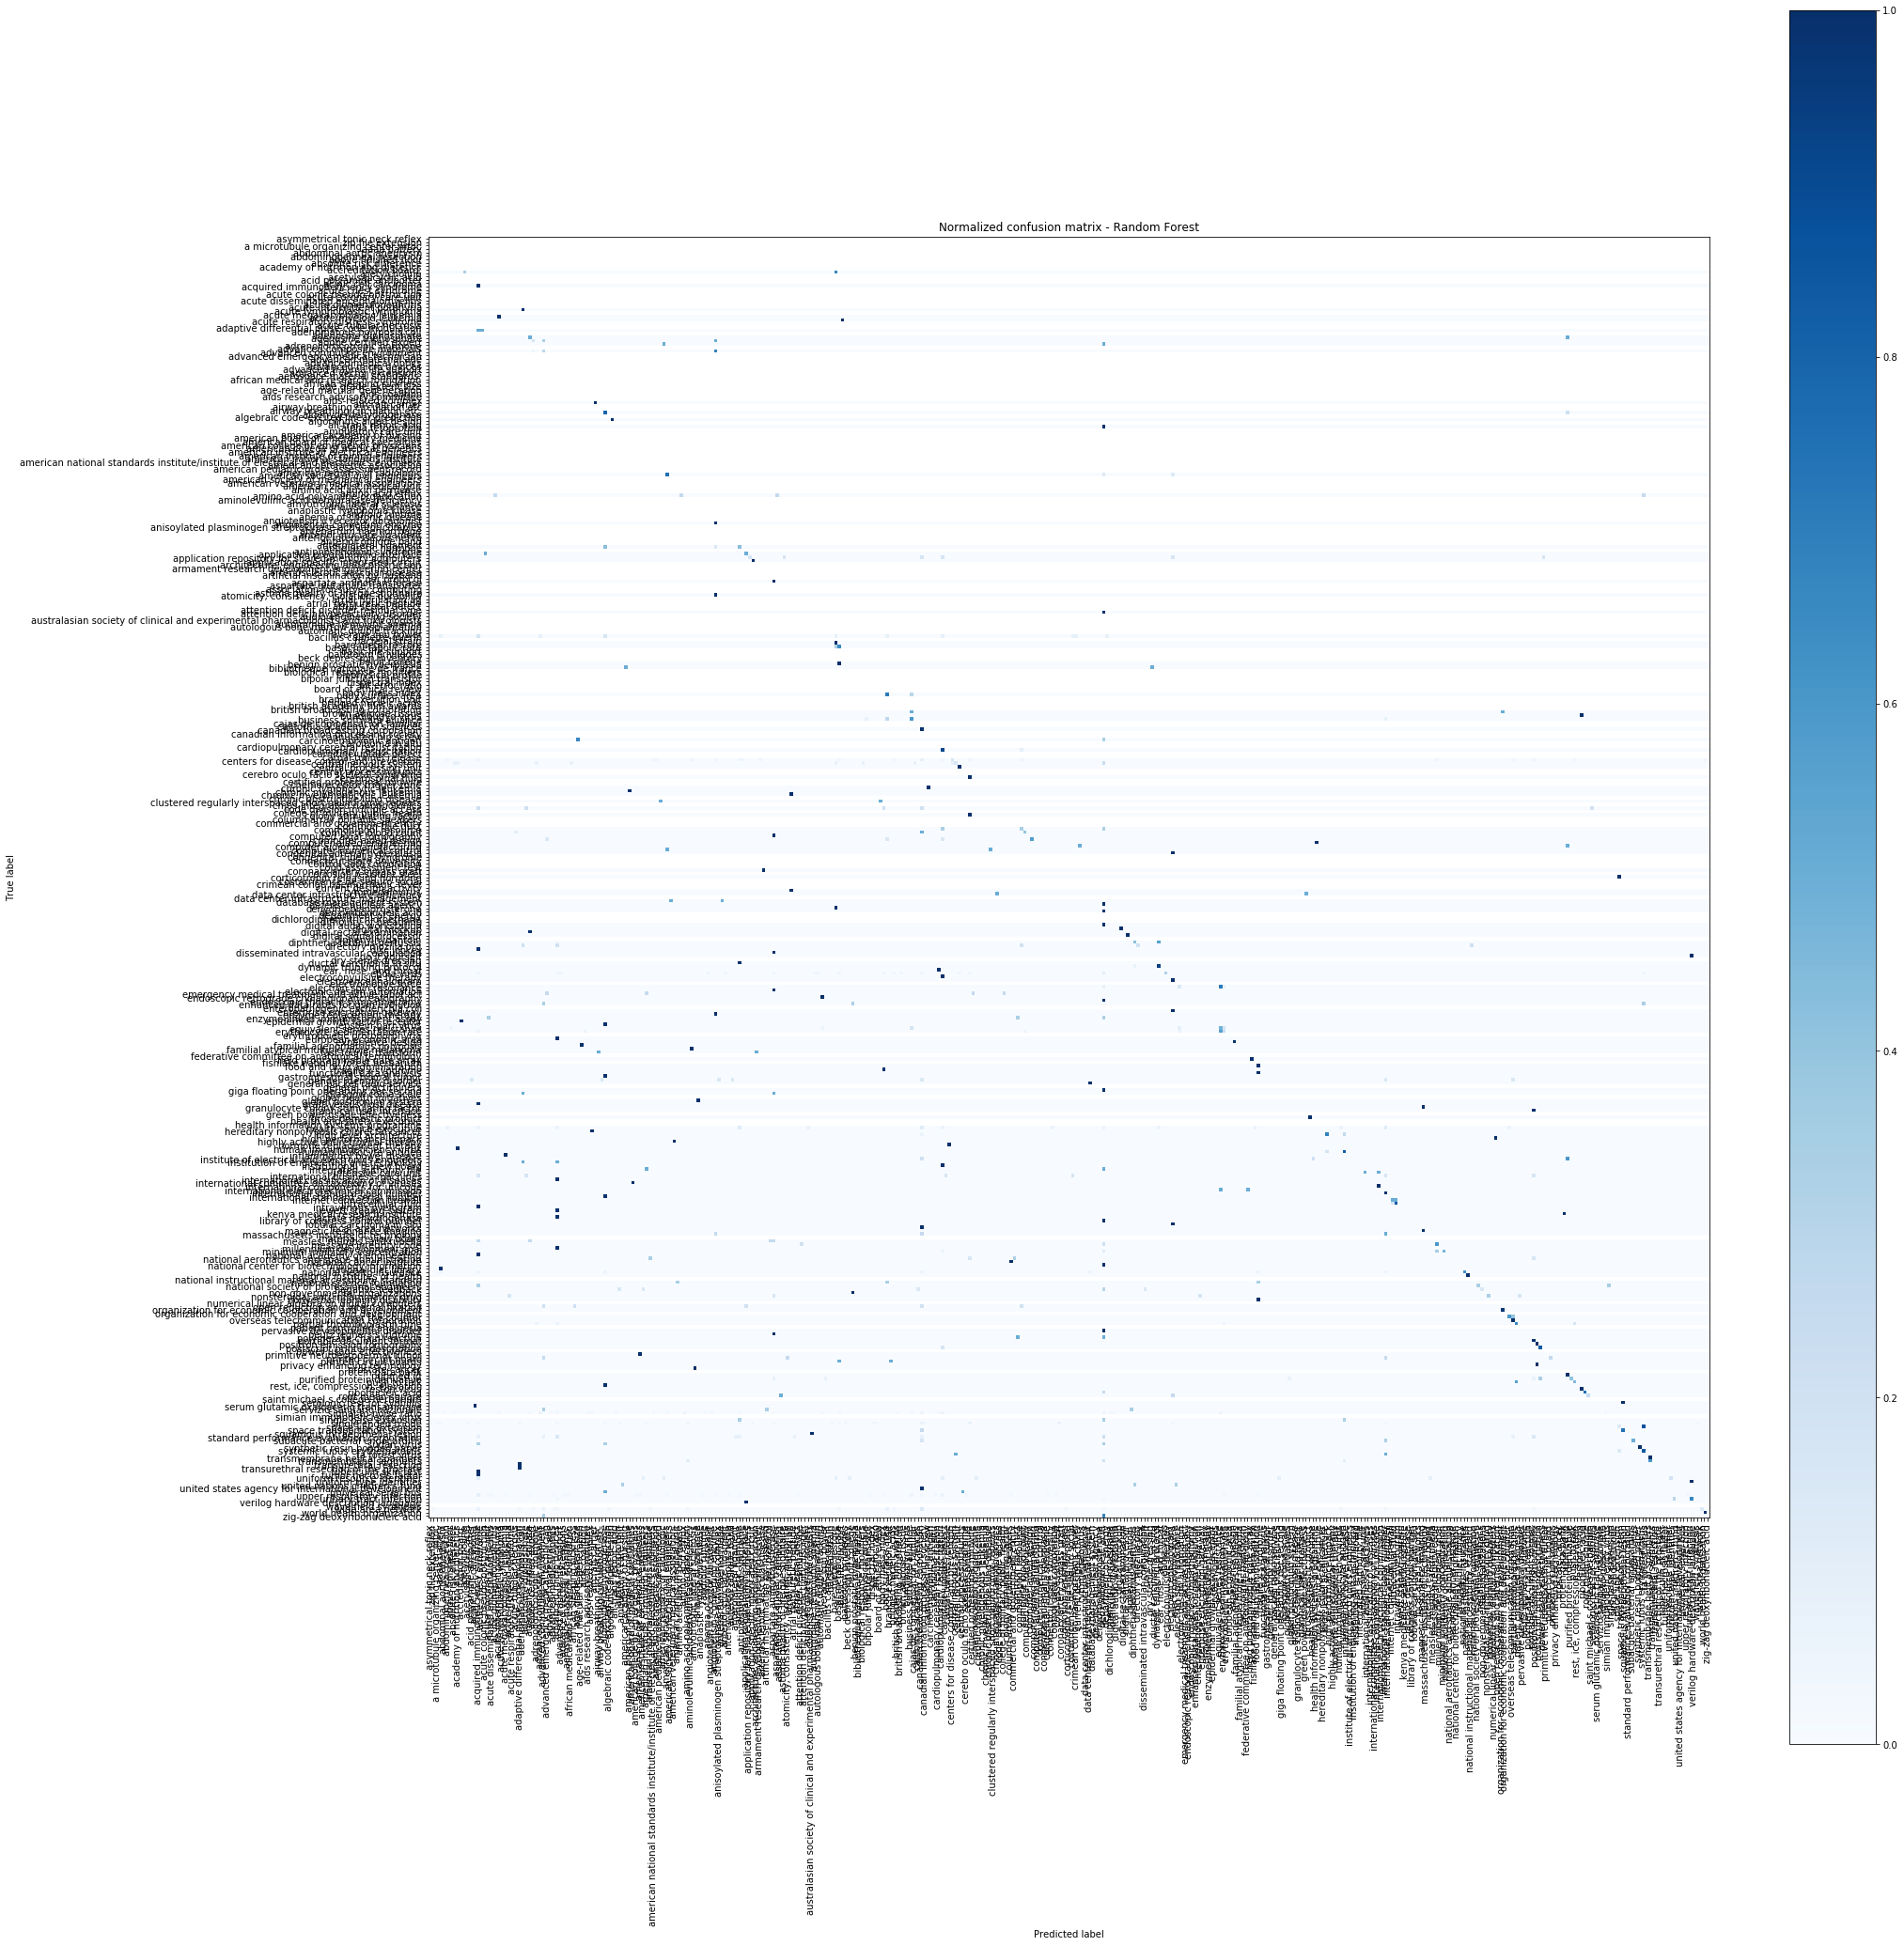

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #plt.text(j, i, format(cm[i, j], fmt),
                 #horizontalalignment="center",
                 #color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# Compute confusion matrix
#cnf_matrix1 = confusion_matrix(y_true_test, predicted1)
cnf_matrix2 = confusion_matrix(y_true_test, predicted2)
cnf_matrix3 = confusion_matrix(y_true_test, predicted3)
cnf_matrix4 = confusion_matrix(y_true_test, predicted4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#class_names1 = sorted(list(set(predicted1).union(set(y_true_test))))
class_names2 = sorted(list(set(predicted2).union(set(y_true_test))))
class_names3 = sorted(list(set(predicted3).union(set(y_true_test))))
class_names4 = sorted(list(set(predicted4).union(set(y_true_test))))
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure(figsize=(30,30))
#plot_confusion_matrix(cnf_matrix1, classes=class_names1, normalize=True,
#                      title='Normalized confusion matrix - Multinomial NB')
#plt.show()

plt.figure(figsize=(30,30))
plot_confusion_matrix(cnf_matrix2, classes=class_names2, normalize=True,
                      title='Normalized confusion matrix - SVC')
plt.show()

plt.figure(figsize=(30,30))
plot_confusion_matrix(cnf_matrix3, classes=class_names3, normalize=True,
                      title='Normalized confusion matrix - Decision Tree')
plt.show()

plt.figure(figsize=(30,30))
plot_confusion_matrix(cnf_matrix4, classes=class_names4, normalize=True,
                      title='Normalized confusion matrix - Random Forest')
plt.show()



In [50]:
testDataDuplicates = []
y_true_test_duplicates = []
for fl in (testingUrlsDuplicates):
    try:
        html = urlopen(fl).read()
    except:
        continue
    rawText = clean_html(html)
    footerIndices = [i for i, x in enumerate(rawText) if x.lower()=='references']
    headerIndices = [i for i, x in enumerate(rawText) if x.lower()=='abstract']
    if(len(footerIndices)>0): rawText = rawText[:max(footerIndices)] #remove extraneous information
    if(len(headerIndices)>0): rawText = rawText[max(headerIndices):] #remove extraneous information

    def findContext(acronym, i):
        startIndex=i-15
        if (i-10 < 0): startIndex=0
        endIndex = i+15 
        if (i+10 > len(rawText)): endIndex = len(rawText)-1
        context = []
        for word in rawText[startIndex:endIndex+1]:
            word = word.lower()
            word = "".join(re.findall("[a-zA-Z]+", word))
            if(len(word)==0 or word==acronym.lower()): continue
            context.append(word)
        return " ".join(context)

    #Populate PostGres Database
    acronyms = identifyAcronyms(rawText) #list of all acronyms and corresponding index in rawtext
    for acronym, i in acronyms:
        if(db.getTrueDefinition(acronym, fl)==None): continue #Definition has been labeled in database
        if(db.getTrueDefinition(acronym, fl) not in y_true): continue
        context = findContext(acronym, i)
        testDataDuplicates.append((acronym, context))
        y_true_test_duplicates.append(db.getTrueDefinition(acronym, fl))        


In [51]:
X_new_counts_duplicates = vect.transform(features(d) for d in testDataDuplicates)
#predicted1 = clf1.predict(X_new_counts_duplicates)
predicted2 = clf2.predict(X_new_counts_duplicates)
predicted3 = clf3.predict(X_new_counts_duplicates)
predicted4 = clf4.predict(X_new_counts_duplicates)

#for test, definition, true in zip(testDataDuplicates, predicted, y_true_test_duplicates):
    #if(definition==true): print('Correct: %s => %s, %s' % (test[0], definition, true))
#    if(definition!=true): print('Error: %s => %s, %s' % (test[0], definition, true))
#print "Prediction Accuracy - Multinomial NB: ", accuracy_score(y_true_test_duplicates, predicted1)
#print metrics.precision_recall_fscore_support(y_true_test_duplicates, predicted1, average='weighted')
print "Prediction Accuracy - SVC: ", accuracy_score(y_true_test_duplicates, predicted2)
print metrics.precision_recall_fscore_support(y_true_test_duplicates, predicted2, average='weighted')
print "Prediction Accuracy - Decision Tree: ", accuracy_score(y_true_test_duplicates, predicted3)
print metrics.precision_recall_fscore_support(y_true_test_duplicates, predicted3, average='weighted')
print "Prediction Accuracy - Random Forest: ", accuracy_score(y_true_test_duplicates, predicted4)
print metrics.precision_recall_fscore_support(y_true_test_duplicates, predicted4, average='weighted')
#print(metrics.classification_report(y_true_test_duplicates, predicted1))
#print(metrics.classification_report(y_true_test_duplicates, predicted2))
#print(metrics.classification_report(y_true_test_duplicates, predicted3))
#print(metrics.classification_report(y_true_test_duplicates, predicted4))

Prediction Accuracy - SVC:  0.860540540541
(0.8741553678781655, 0.86054054054054052, 0.85308900124893061, None)
Prediction Accuracy - Decision Tree:  0.739459459459
(0.80573859969543749, 0.73945945945945946, 0.74921506051899245, None)
Prediction Accuracy - Random Forest:  0.664864864865
(0.76393491921924328, 0.66486486486486485, 0.66538769845842705, None)


/Users/mayavarma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


Normalized confusion matrix
[[ 0.    0.5   0.   ...,  0.    0.    0.  ]
 [ 0.    0.5   0.   ...,  0.    0.    0.  ]
 [ 0.    0.    1.   ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  1.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.82  0.  ]
 [ 0.    0.    0.   ...,  0.17  0.    0.83]]


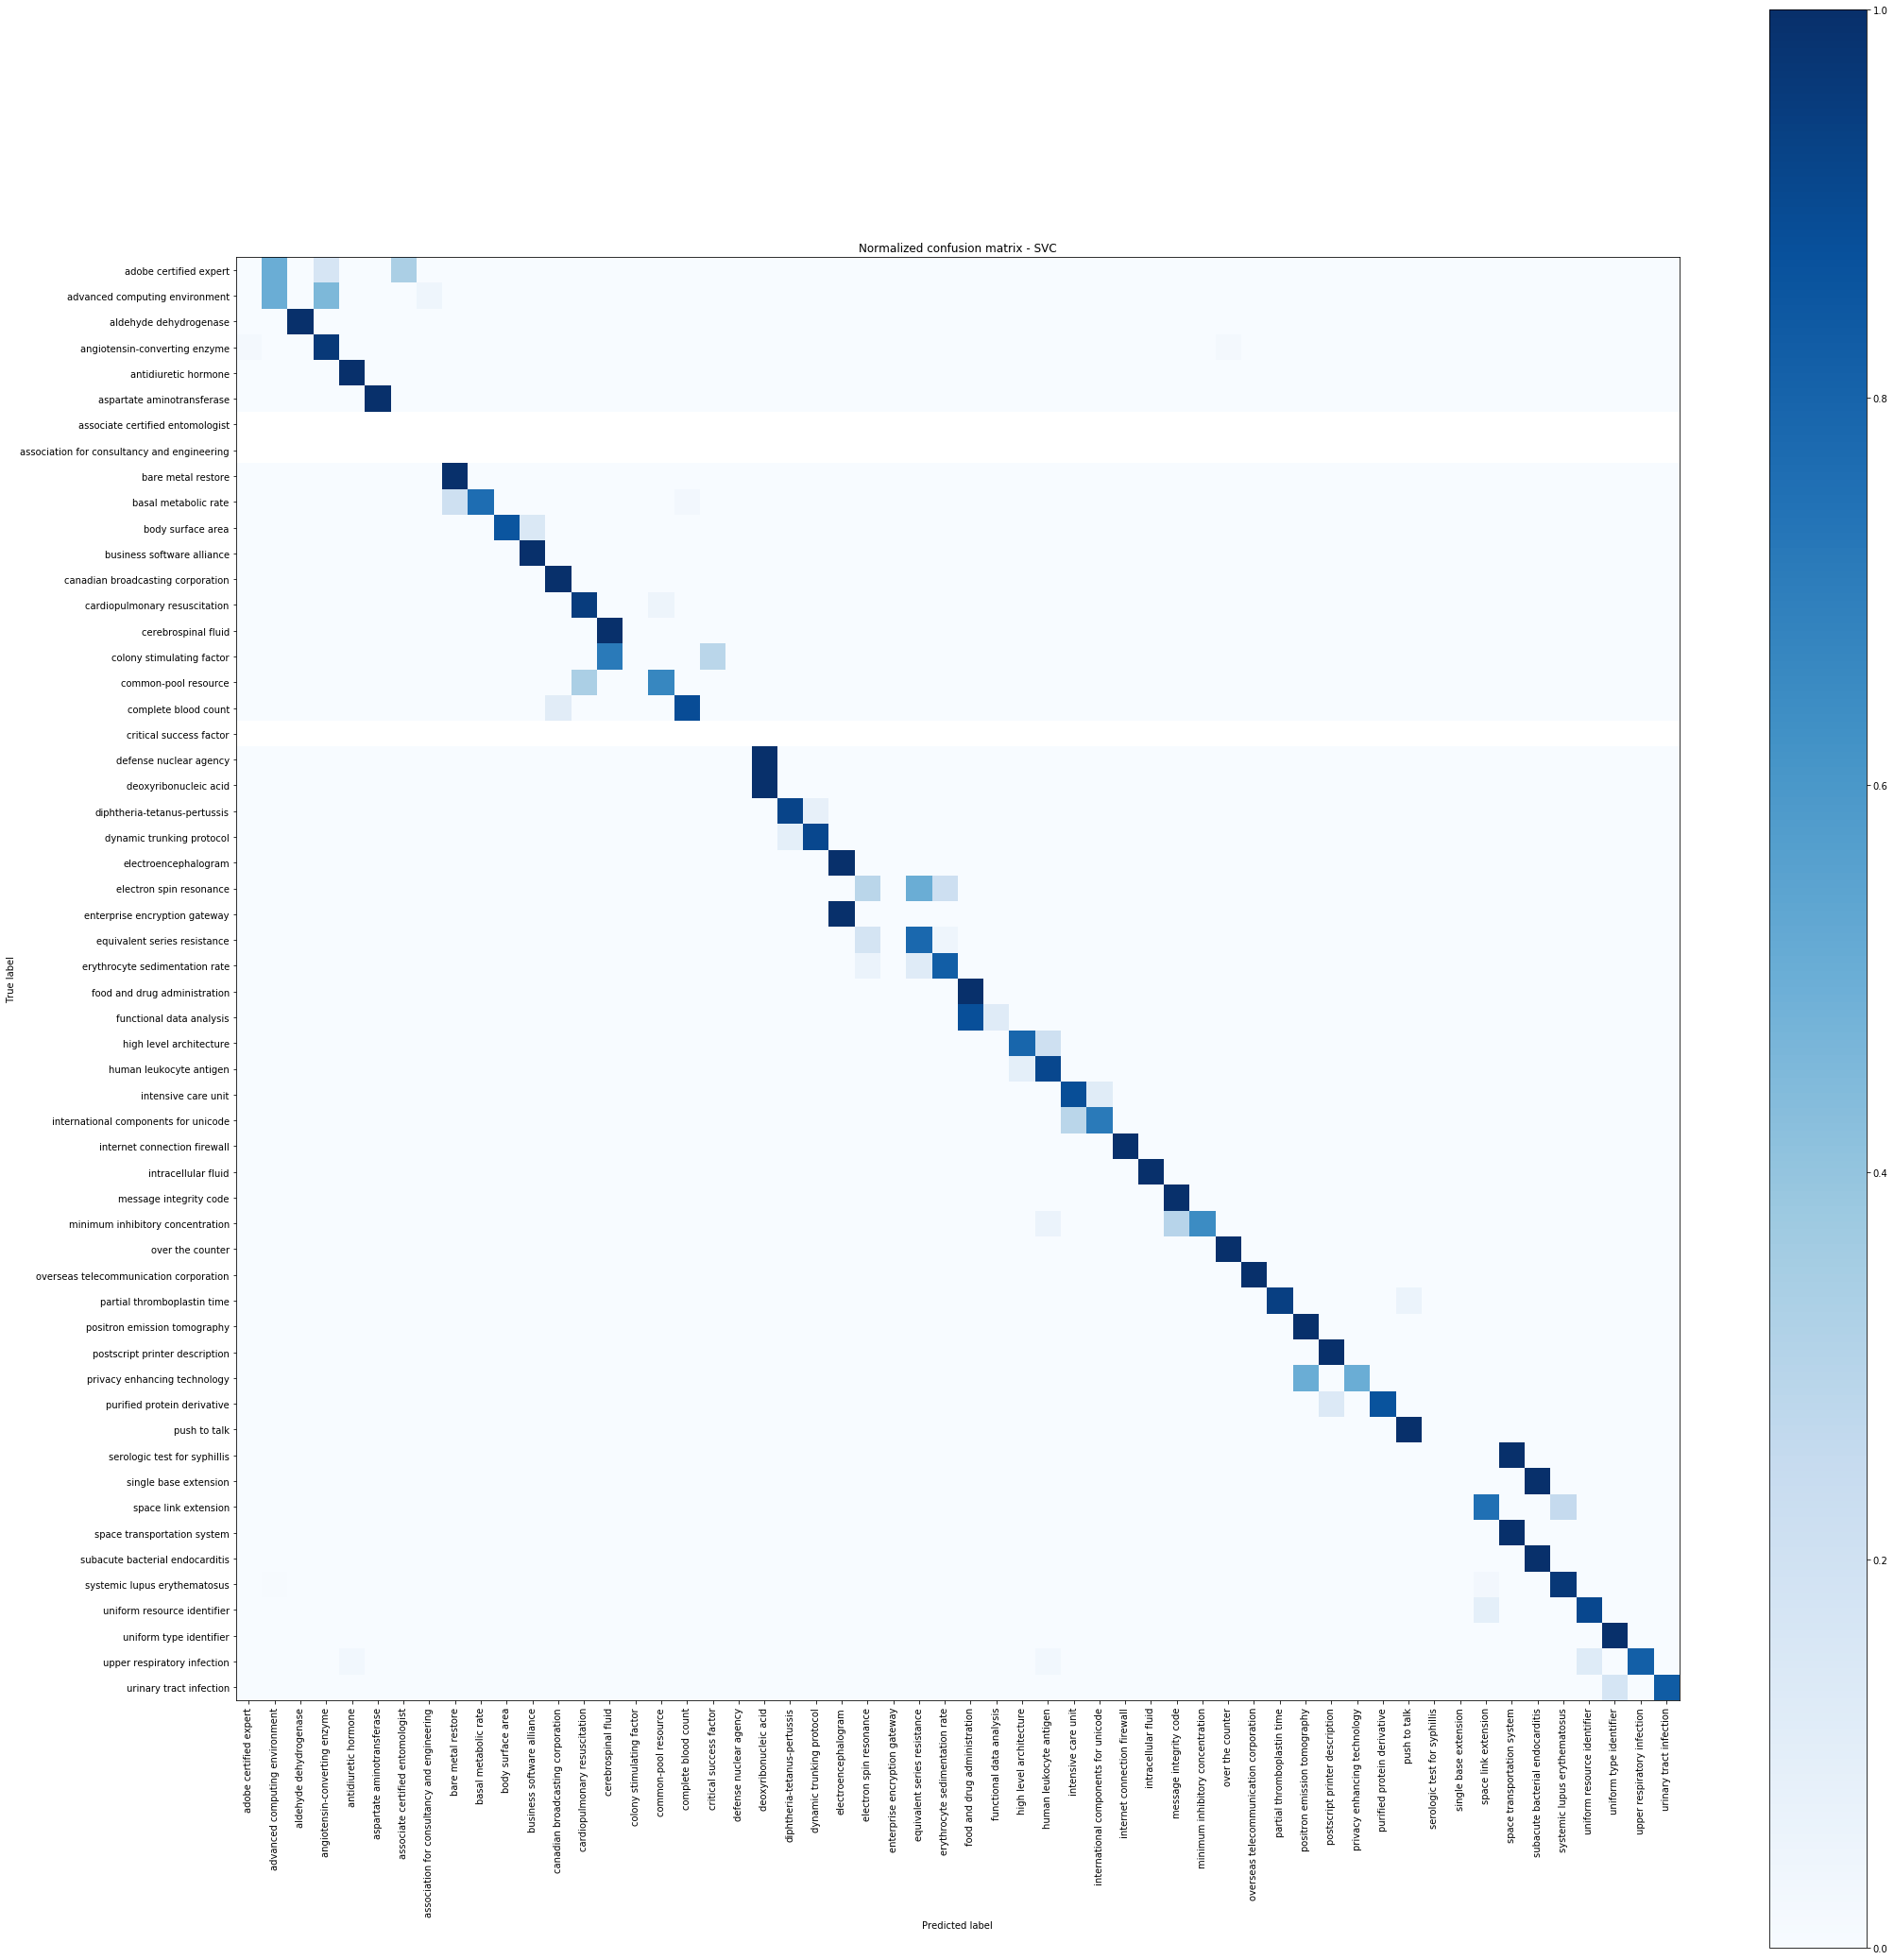

Normalized confusion matrix
[[ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.14  0.   ...,  0.    0.    0.  ]
 [ 0.    0.    1.   ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  0.    0.    1.  ]
 [ 0.    0.    0.   ...,  0.    0.76  0.  ]
 [ 0.    0.    0.   ...,  0.34  0.    0.66]]


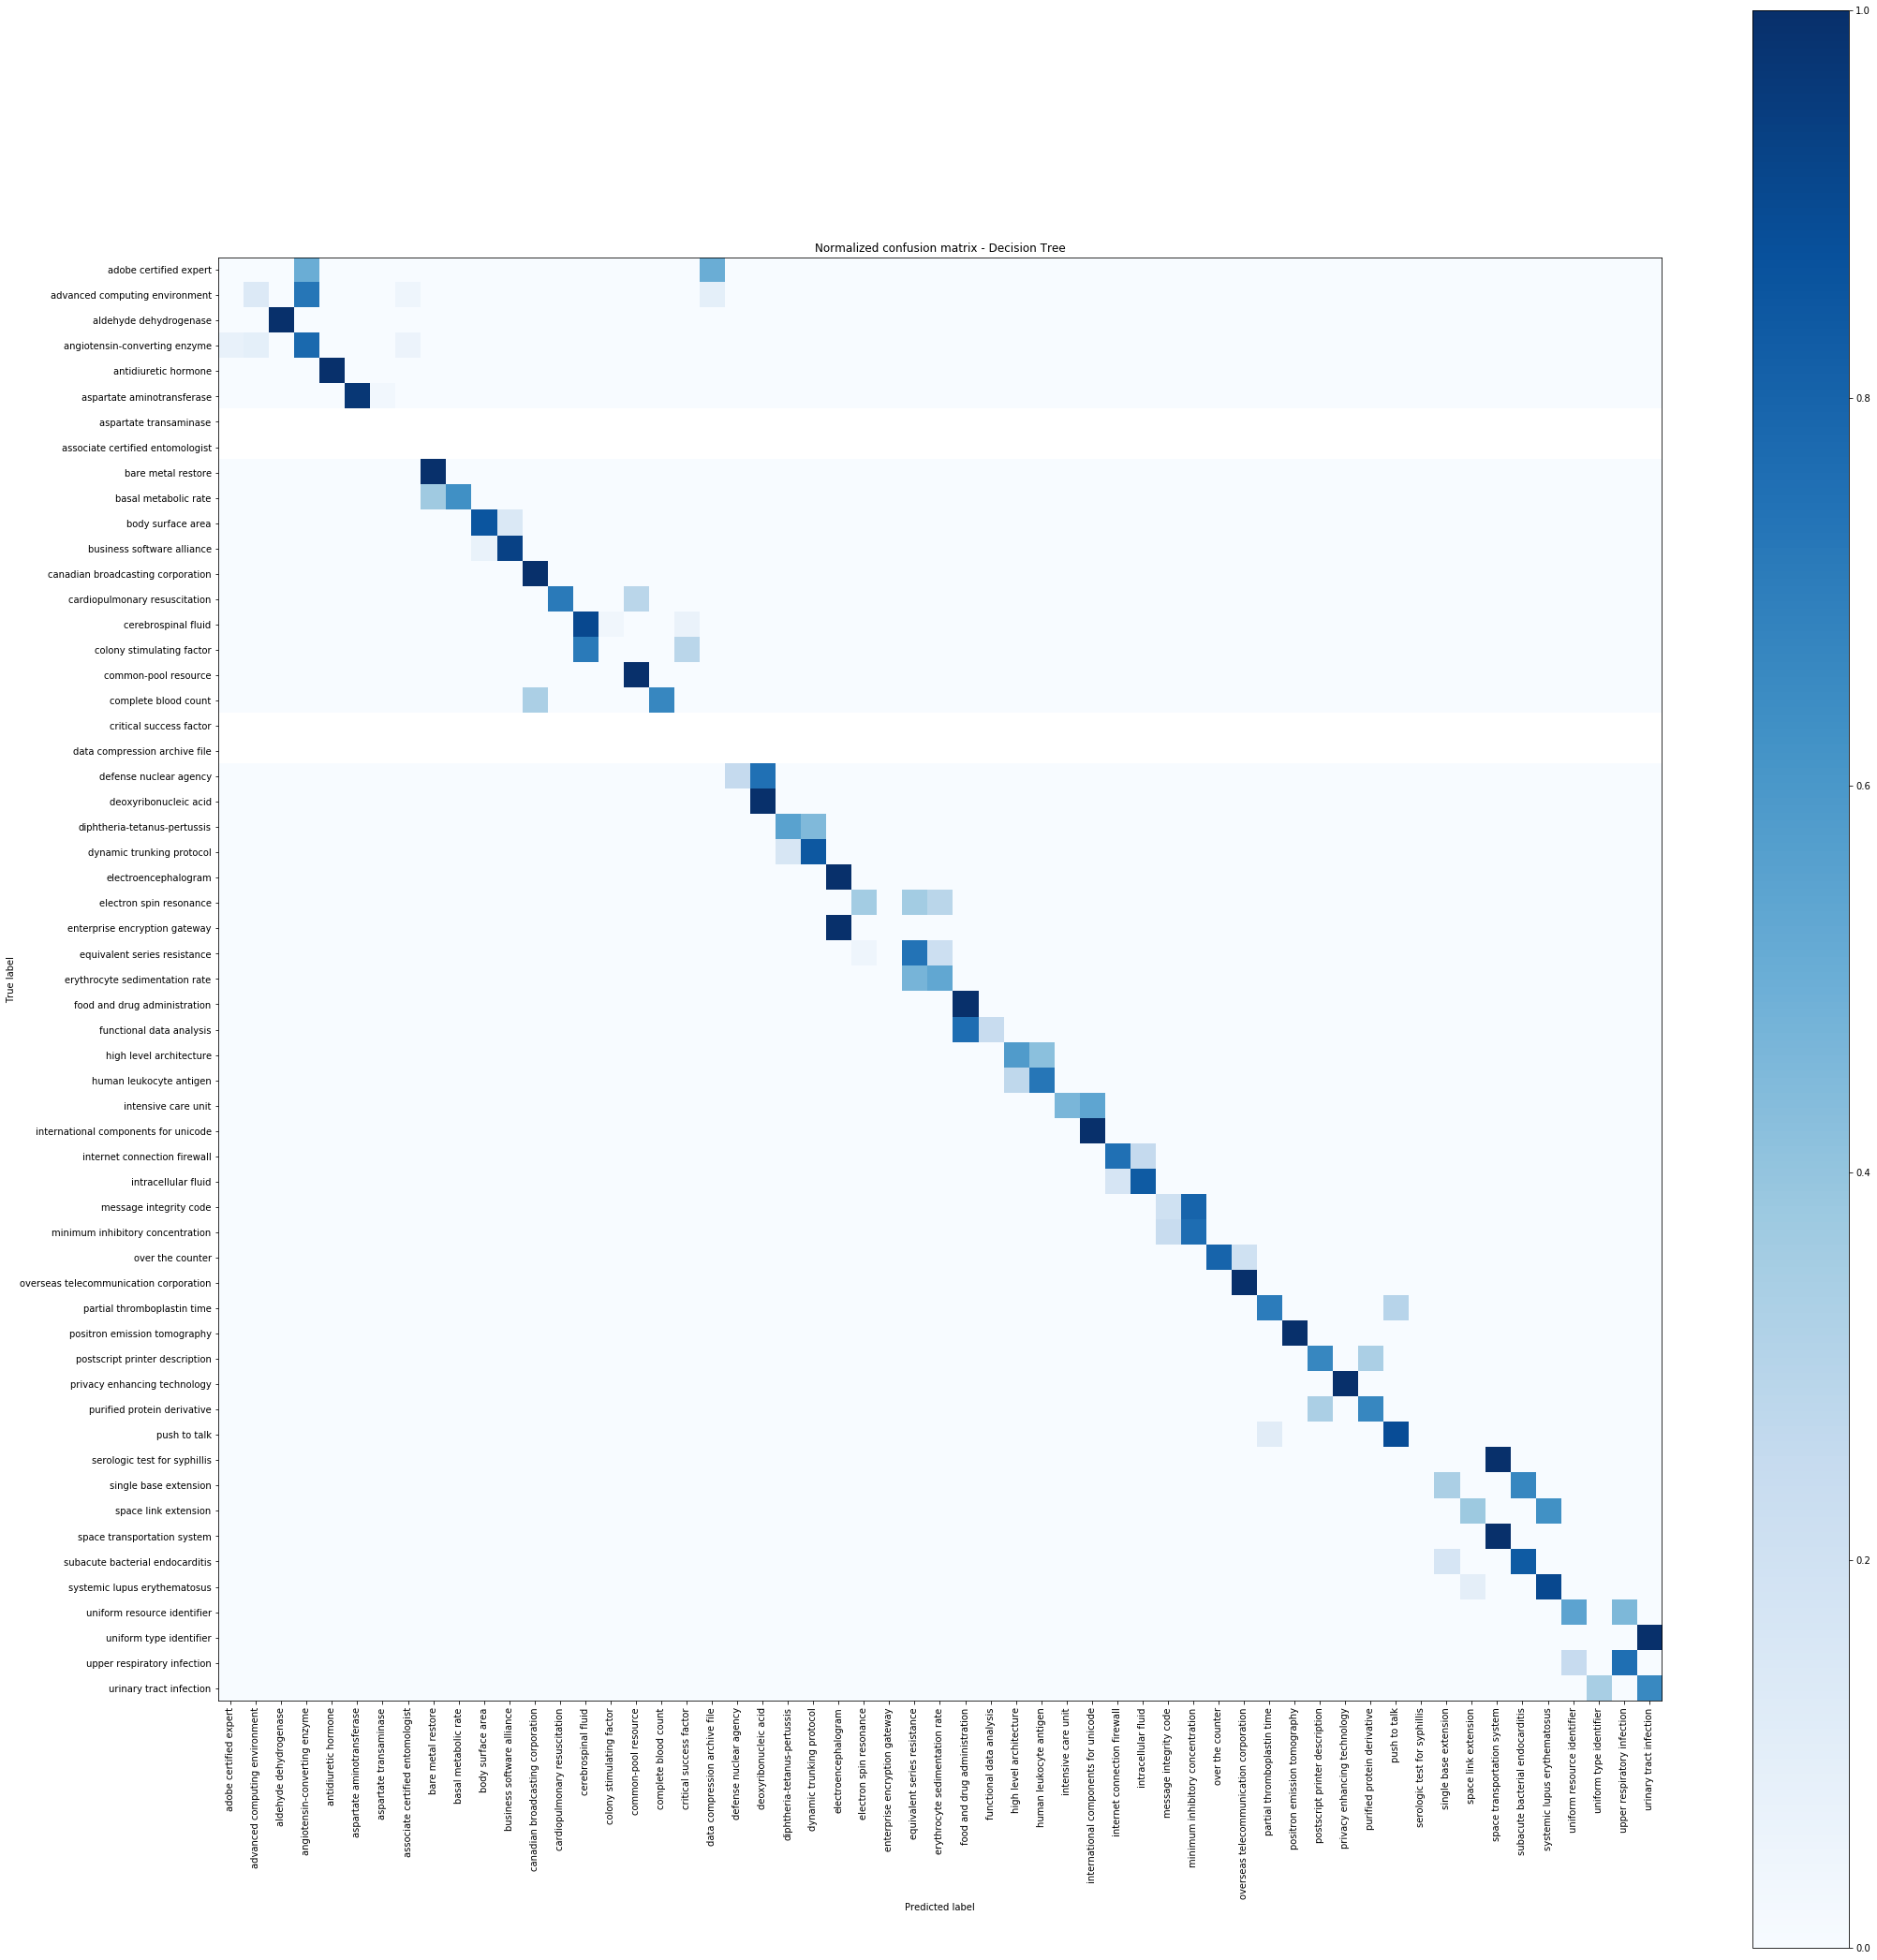

Normalized confusion matrix
[[  nan   nan   nan ...,   nan   nan   nan]
 [  nan   nan   nan ...,   nan   nan   nan]
 [  nan   nan   nan ...,   nan   nan   nan]
 ..., 
 [ 0.    0.    0.   ...,  0.    0.    1.  ]
 [ 0.    0.09  0.03 ...,  0.    0.03  0.  ]
 [ 0.    0.    0.   ...,  0.29  0.    0.66]]


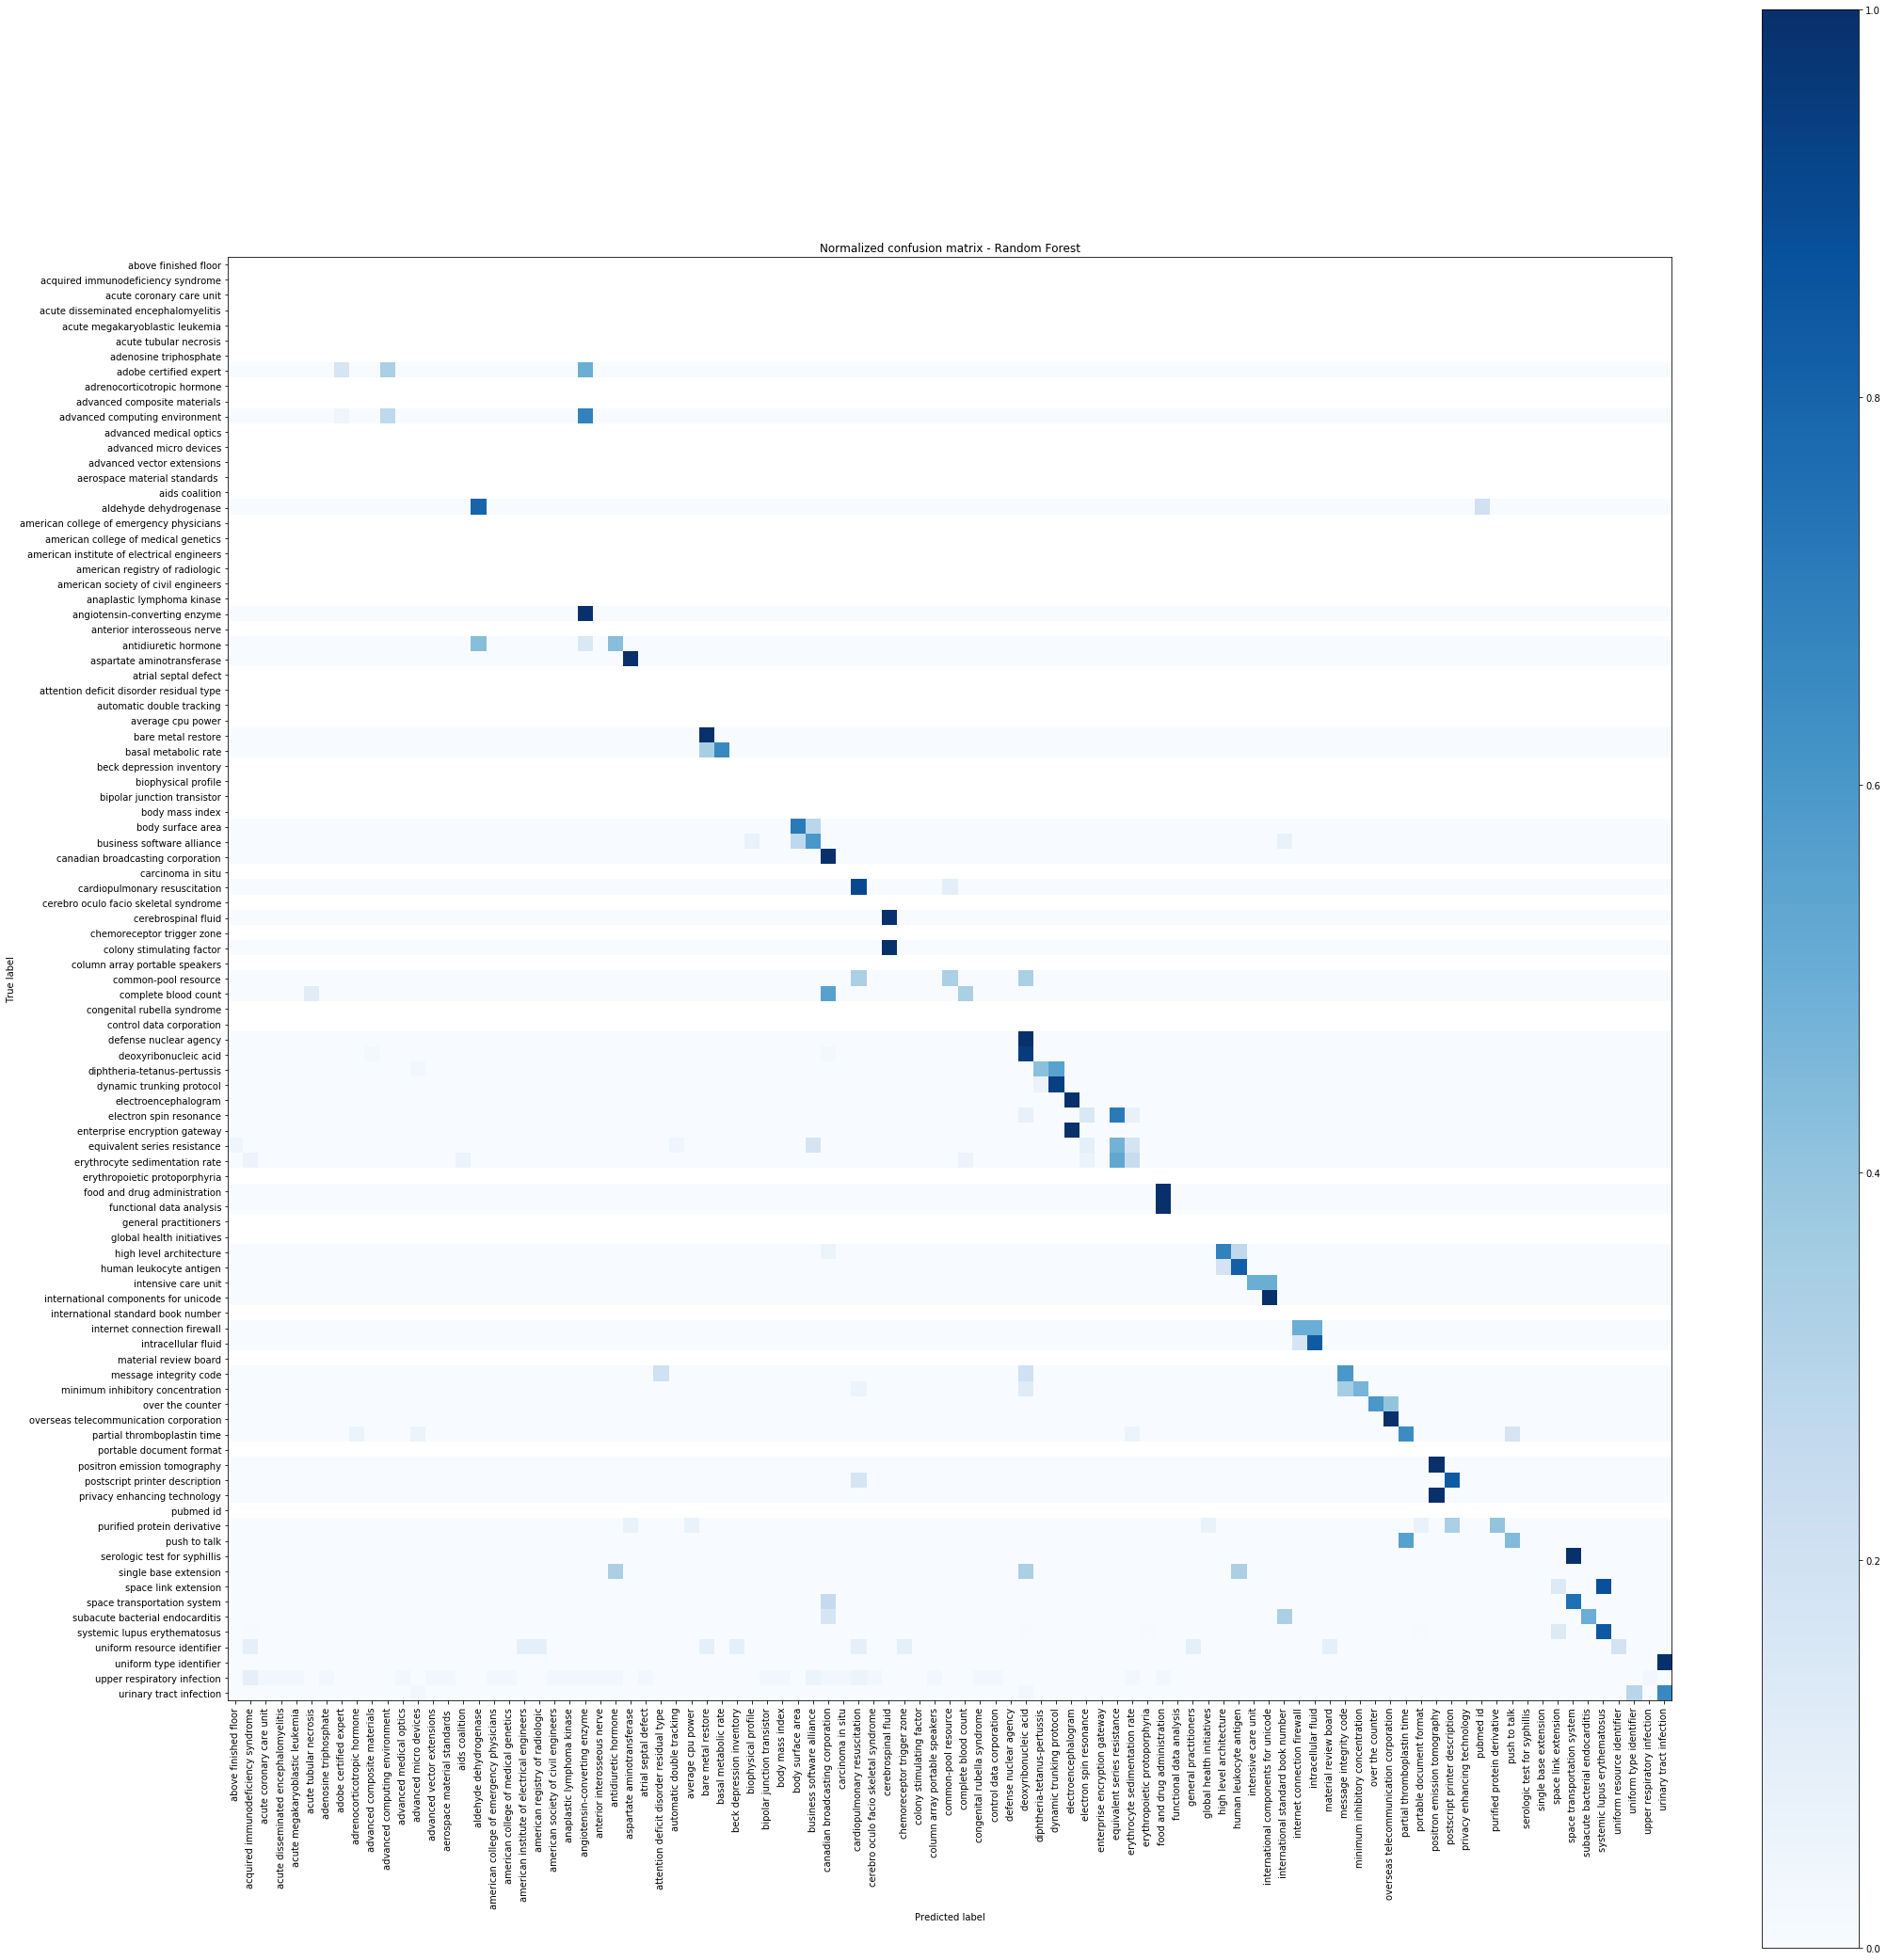

In [52]:
# Compute confusion matrix
#cnf_matrix1 = confusion_matrix(y_true_test_duplicates, predicted1)
cnf_matrix2 = confusion_matrix(y_true_test_duplicates, predicted2)
cnf_matrix3 = confusion_matrix(y_true_test_duplicates, predicted3)
cnf_matrix4 = confusion_matrix(y_true_test_duplicates, predicted4)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure(figsize=(30,30))
#class_names1 = sorted(list(set(predicted1).union(set(y_true_test_duplicates))))
class_names2 = sorted(list(set(predicted2).union(set(y_true_test_duplicates))))
class_names3 = sorted(list(set(predicted3).union(set(y_true_test_duplicates))))
class_names4 = sorted(list(set(predicted4).union(set(y_true_test_duplicates))))
#print len(class_names)
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure(figsize=(30,30))
#plot_confusion_matrix(cnf_matrix1, classes=class_names1, normalize=True,
#                      title='Normalized confusion matrix - Multinomial NB')
#plt.show()

plt.figure(figsize=(30,30))
plot_confusion_matrix(cnf_matrix2, classes=class_names2, normalize=True,
                      title='Normalized confusion matrix - SVC')
plt.show()

plt.figure(figsize=(30,30))
plot_confusion_matrix(cnf_matrix3, classes=class_names3, normalize=True,
                      title='Normalized confusion matrix - Decision Tree')
plt.show()

plt.figure(figsize=(30,30))
plot_confusion_matrix(cnf_matrix4, classes=class_names4, normalize=True,
                      title='Normalized confusion matrix - Random Forest')
plt.show()


In [ ]:
db.close()